In [1]:
import numpy as np
import glob
import utils.utils as util
import time
import os

class Dataset():
    def __init__(self, args):
        self.trainidx = []
        self.dataset_name = args.dataset_name
        self.path_to_annotations = os.path.join(args.annotation_path, args.dataset_name + '-Annotations/')
        self.path_to_features = os.path.join(args.I3D_path, self.dataset_name + '-I3D-JOINTFeatures.npy')
        self.labels = np.load(self.path_to_annotations + 'labels_all.npy')     # Specific to Thumos14
        self.classlist = np.load(self.path_to_annotations + 'classlist.npy')
        self.subset = np.load(self.path_to_annotations + 'subset.npy')
        self.testidx = []
        self.classwiseidx = []
        self.train_test_idx()
        self.currenttestidx = 0
        self.t_max = args.max_seqlen
        self.num_class = args.num_class
        self.classwise_feature_mapping()
        self.batch_size = args.batch_size
        self.feature_size = args.feature_size
        self.features = np.load(self.path_to_features, encoding='bytes')
        self.segments = np.load(self.path_to_annotations + 'segments.npy')
        self.labels_multihot = [util.strlist2multihot(labs,self.classlist) for labs in self.labels]


    def train_test_idx(self):
        for i, s in enumerate(self.subset):
            if s.decode('utf-8') == 'validation':   # Specific to Thumos14
                self.trainidx.append(i)
            else:
                self.testidx.append(i)

    def classwise_feature_mapping(self):
        for category in self.classlist:
            idx = []
            for i in self.trainidx:
                for label in self.labels[i]:
                    if label == category.decode('utf-8'):
                        idx.append(i); break;
            self.classwiseidx.append(idx)


    def load_data(self, n_similar=3, is_training=True):
        if is_training==True:
            features = []
            labels = []
            idx = []

            # Load similar pairs
            rand_classid = np.random.choice(len(self.classwiseidx), size=n_similar)
            for rid in rand_classid:
                rand_sampleid = np.random.choice(len(self.classwiseidx[rid]), size=2)
                idx.append(self.classwiseidx[rid][rand_sampleid[0]])
                idx.append(self.classwiseidx[rid][rand_sampleid[1]])

            # Load rest pairs
            rand_sampleid = np.random.choice(len(self.trainidx), size=self.batch_size-2*n_similar)
            for r in rand_sampleid:
                idx.append(self.trainidx[r])
          
            return np.array([util.process_feat(self.features[i], self.t_max) for i in idx]), np.array([self.labels_multihot[i] for i in idx])

        else:
            labs = self.labels_multihot[self.testidx[self.currenttestidx]]
            feat = self.features[self.testidx[self.currenttestidx]]

            if self.currenttestidx == len(self.testidx)-1:
                done = True; self.currenttestidx = 0
            else:
                done = False; self.currenttestidx += 1
         
            return np.array(feat), np.array(labs), done

In [2]:
import utils.options
import torch
import torch.nn as nn

class Args():
    def __init__(self):
        self.lr = 0.0001
        self.dataset_name = 'Thumos14reduced'
        self.num_class = 20
        self.feature_size = 2048
        self.batch_size = 24
        self.max_seqlen = 750
        self.model_name = 'weakloc'
        self.pretrained_ckpt = None
        self.max_iter = 50000
        self.num_similar = 3
        self.checkpoint_path = './checkpoint/'
        self.annotation_path = './annotations/'
        self.I3D_path = './I3D_features/'

args = Args()

# Load the dataset
dataset = Dataset(args)

In [3]:
# Attention Module
# Test

class Attention_Module(nn.Module):
    """Args:
    feature_dim: dimension of the feature from I3D model.
    """

    def __init__(self, feature_dim):
        super(Attention_Module, self).__init__()
        
        self.feature_dim = feature_dim
        self.fc0 = nn.Linear(feature_dim, 1024)
        self.fc1 = nn.Linear(1024, 256)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        self.fc3 = nn.Linear(2048, 20)

    def forward(self, features_list):
        """Build the attention module.

        Args:
        features_list: (batch_size, num_frame, feat_depth)

        Returns:
        The attention weights, weigted features
        """
        
        attention_weights = []
        weighted_features = []
        
        # Iterate through batch
        for idx, video_features in enumerate(features_list):
                        
            # Trunk feature into real length
            seq_len = (torch.abs(video_features).max(dim=1)[0] > 0).sum().tolist()
            video_features = video_features[: seq_len, :]
            
            # Iterate through video segments
            output = self.sigmoid(self.fc2(self.relu(self.fc1(self.relu(self.fc0(video_features))))))

            # Temporal Pool
            weighted_pooling = (output*video_features).sum(0)/video_features.shape[0]
            
            # Save weights/features
            output = output.reshape(output.shape[0])
            attention_weights.append(output)
            weighted_features.append(weighted_pooling)
            
        # Reshape to tensor
        weighted_features = torch.stack(weighted_features)
        
        predict = self.sigmoid(self.fc3(weighted_features))
        
        return attention_weights, weighted_features, predict


def l1_norm(inputs):
    norm_value = torch.zeros(len(inputs)).cuda()
    for idx, vector in enumerate(inputs):
        norm_value[idx] = torch.norm(torch.abs(vector), p=1)
    return norm_value.sum()


def multi_to_single(labels):
    l = []
    for lab in labels:
        l.append(lab.tolist().index(1))
    return torch.from_numpy(np.asarray(l)).cuda()


# T-cam function
def t_cam(model, features, segment_len, cls_num=20):
    """
        return (segments, class_num)
    """
    weights = torch.zeros(segment_len, cls_num)
    for i in range(segment_len):
        for j in range(cls_num):
            weights[i, j] = (features[i]*model.fc3.weight[j]).sum()
    return weights


# T-cam with specific label
def temporal_proposals(weights, features, clses):
    """
        Return the binary temporal proposals based on T-CAM.
        Input: 
            features:    (batch, # of segments, # of dim)
            cls:         (batch, class_label)
        Return:    [batch, # of untrimmed segments(binary)]
    """
    proposals = []
    # Iterate through batch
    for idx, video_feature in enumerate(features):
        # Trunk video feature to real length
            seq_len = (torch.abs(video_feature).max(dim=1)[0] > 0).sum().tolist()
            video_feature = video_feature[: seq_len, :]
            scores = np.zeros(seq_len)
            for seg_id, feature in enumerate(video_feature):
                for cls in clses[idx]:
                    score = (feature*weights[cls]).sum()
                    scores[seg_id] += score
            threshold = (np.max(scores) - (np.max(scores) - np.min(scores))*0.5)
            proposals.append([idx for idx, s in enumerate(scores) if s > threshold])

    return proposals

In [42]:
features, labels = dataset.load_data(is_training=True)
features = torch.from_numpy(features)
weights = model.fc3.weight.detach().cpu()
# cls
clses = [[idx for idx, c in enumerate(label) if c == 1.0] for label in labels]

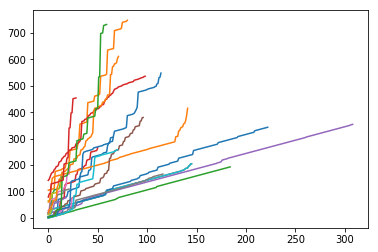

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline  

for p in proposals:
    plt.plot(p)

In [5]:
model = Attention_Module(feature_dim=2048)
checkpoint = torch.load('./checkpoint/temporal_cls_epoch_15000_bceloss.pth')
model.load_state_dict(checkpoint['state_dict'])
epoch = checkpoint['epoch']
model.eval()
model.cuda()
print('model loaded')

model loaded


In [6]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from tensorboard_logger import log_value
import utils
import numpy as np
from torch.autograd import Variable
from utils.classificationMAP import getClassificationMAP as cmAP
from utils.detectionMAP import getDetectionMAP as dmAP
import scipy.io as sio
torch.set_default_tensor_type('torch.cuda.FloatTensor')

def test(itr, dataset, args, model, logger, device):
    
    done = False
    instance_logits_stack = []
    element_logits_stack = []
    labels_stack = []
    while not done:
        if dataset.currenttestidx % 100 ==0:
            print('Testing test data point %d of %d' %(dataset.currenttestidx, len(dataset.testidx)))

        features, labels, done = dataset.load_data(is_training=False)
        features = torch.from_numpy(features).float().to(device)
        
        # Computing T-cam weights
        t_cam_weights = t_cam(model, features, len(features))
        t_cam_weights = t_cam_weights.cpu().data.numpy()

        element_logits_stack.append(t_cam_weights)
        labels_stack.append(labels)
#         print(dataset.currenttestidx)

    labels_stack = np.array(labels_stack)
#     return element_logits_stack, labels_stack

    dmap, iou = dmAP(element_logits_stack, dataset.path_to_annotations)
    
    if args.dataset_name == 'Thumos14':
        test_set = sio.loadmat('test_set_meta.mat')['test_videos'][0]
        for i in range(np.shape(labels_stack)[0]):
            if test_set[i]['background_video'] == 'YES':
                labels_stack[i, :] = np.zeros_like(labels_stack[i,:])

    print('Detection map @ %f = %f' %(iou[0], dmap[0]))
    print('Detection map @ %f = %f' %(iou[1], dmap[1]))
    print('Detection map @ %f = %f' %(iou[2], dmap[2]))
    print('Detection map @ %f = %f' %(iou[3], dmap[3]))
    print('Detection map @ %f = %f' %(iou[4], dmap[4]))
        
#     logger.log_value('Test Classification mAP', cmap, itr)
#     for item in list(zip(dmap,iou)):
#     	logger.log_value('Test Detection mAP @ IoU = ' + str(item[1]), item[0], itr)
    return element_logits_stack, labels_stack

#     utils.write_to_file(args.dataset_name, dmap, cmap, itr)

In [7]:
from tensorboard_logger import Logger
logger = Logger('./logs/' + 'Testing')
device = torch.device("cuda")

element_logits_stack, labels_stack = test(0, dataset, args, model, logger, device)

Testing test data point 0 of 212
Testing test data point 100 of 212
Testing test data point 200 of 212
Testing for IoU 0.100000
Testing for IoU 0.200000
Testing for IoU 0.300000
Testing for IoU 0.400000
Testing for IoU 0.500000
Detection map @ 0.100000 = 37.418052
Detection map @ 0.200000 = 31.486944
Detection map @ 0.300000 = 21.474831
Detection map @ 0.400000 = 14.364203
Detection map @ 0.500000 = 9.033523


In [209]:
    if args.dataset_name == 'Thumos14':
        test_set = sio.loadmat('test_set_meta.mat')['test_videos'][0]
        for i in range(np.shape(labels_stack)[0]):
            if test_set[i]['background_video'] == 'YES':
                labels_stack[i, :] = np.zeros_like(labels_stack[i,:])

    print('Detection map @ %f = %f' %(iou[0], dmap[0]))
    print('Detection map @ %f = %f' %(iou[1], dmap[1]))
    print('Detection map @ %f = %f' %(iou[2], dmap[2]))
    print('Detection map @ %f = %f' %(iou[3], dmap[3]))
    print('Detection map @ %f = %f' %(iou[4], dmap[4]))

Detection map @ 0.100000 = 37.418052
Detection map @ 0.200000 = 31.486944
Detection map @ 0.300000 = 21.474831
Detection map @ 0.400000 = 14.364203
Detection map @ 0.500000 = 9.033523
